## Parameters

In [1]:
save_loc = "saved/toy_seqs"
ae_loc = save_loc
data_loc = save_loc

BATCH_SIZE = 32

root_logdir = "logs"
reps = 1 #5
epochs = 1# 81
EARLY_STOP = 4


from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta

## Full 
flow_depth_options = [5, 10, 15]
inter_dims_options = [[1024, 128, 32], ]
optimizer_options = [Adam(), RMSprop()]
beta_options = [0.2, 0.5, 0.8, 1.0]
gamma_options = [2.0, 1.0]


## Quick 
flow_depth_options = [5]
inter_dims_options = [[1024, 128, 32], ]
optimizer_options = [Adam()]
beta_options = [0.5]
gamma_options = [2.0]

## Imports

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy


from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split
import time

from my_lib.save_load import load_datasets, load_seq_vae, save_ilvm
from my_lib.models.vae_sequence import START, SCALE
from my_lib.models.common_functions import sampling2, Linear, log_normal_pdf
from my_lib.models.planar_flows import PlanarFlow
from my_lib.models.filvm import FILVM 
from my_lib.helpers import walk_ld, make_plots, make_id, param_search_to_list

## Load training data

In [3]:
all_data = load_datasets(data_loc)


print("\nColumns of s are: start, stop, step, length\n")
for name, model in all_data.items():
    name = name.split(".")[0]
    exec("{} = model".format(name))
    print("initialized variable,", name)
    
max_len = max(s_tr[:,-1])
print("\nMax seq lenght is", max_len)

all_seqs = []
lens_tr = s_tr[:,-1].copy()
lens_cv = s_cv[:,-1].copy()

for s in (s_tr, s_cv):
    # create seqs
    eff_stops = s[:,0] + s[:, 2]*max_len
    expanded_seqs = [np.arange(x[0],eff_s, x[2] ) for x, eff_s in zip(s, eff_stops)]
    all_seqs.append(expanded_seqs)
    
    # scale each attribute 
    for i in range(s.shape[1]):
        low, high = float(min(s[:,i])), float(max(s[:,i]))
        s[:,i] = (s[:,i]-low) / (high-low)
        
all_seqs_tr, all_seqs_cv = all_seqs

failed to load .ipynb_checkpoints (This is probably fine, unless it's needed)

Columns of s are: start, stop, step, length

initialized variable, s_cv
initialized variable, s_tr

Max seq lenght is 29.0


In [4]:

seqs_tr = tf.expand_dims(
            tf.keras.preprocessing.sequence.pad_sequences(all_seqs_tr, 
                                                          padding='post', dtype="float32"), -1)
mask = tf.expand_dims(tf.sequence_mask(lens_tr, dtype=tf.float32, maxlen=seqs_tr.shape[1]),-1)
seqs_tr *= mask


seqs_cv = tf.expand_dims(
            tf.keras.preprocessing.sequence.pad_sequences(all_seqs_cv, 
                                                          padding='post', dtype="float32"), -1)
mask = tf.expand_dims(tf.sequence_mask(lens_cv, dtype=tf.float32, maxlen=seqs_cv.shape[1]),-1)
seqs_cv *= mask


dataset_cv = tf.data.Dataset.from_tensor_slices((seqs_cv/SCALE, lens_cv)).shuffle(len(seqs_cv))
dataset_cv = dataset_cv.batch(32, drop_remainder=True)

## Load VAE

In [5]:
vae = load_seq_vae(ae_loc)

encoder = vae.encoder 
decoder =  vae.decoder 
len_decoder = vae.len_decoder

## Set up filvm training data

In [8]:
#pick 2 to use, order is: start, step, seq_len
sdims =(0,2)  #pair of dims

In [10]:
z_train, _, _ = vae.encoder(seqs_tr/SCALE)
latent_dim = z_train.shape[1]

<tf.Tensor: shape=(95000, 4), dtype=float32, numpy=
array([[-7.2973484e-01,  4.5488924e-01,  3.7473702e+00,  8.2831210e-01],
       [-1.6914479e-02,  7.2445452e-02,  9.6377343e-01,  5.2841145e-01],
       [-3.8134187e-01, -3.5838157e-01,  1.9247752e+00,  6.7973870e-01],
       ...,
       [-1.3440921e+00, -2.0610993e+00,  2.6150589e+00, -1.3419989e+00],
       [-4.7550105e-02, -1.3422701e-03,  7.8499317e-01,  3.7660229e-01],
       [-1.5218327e+00, -1.6467276e+00,  2.9911668e+00, -1.1128243e+00]],
      dtype=float32)>

In [11]:
z_train1, z_train2, s0_1, s0_2, s1_1, s1_2, = train_test_split(z_train.numpy(),
                                                                s_tr[:,sdims[0]], 
                                                                s_tr[:,sdims[1]], 
                                                                test_size= 0.5,
                                                             )

z_train1 = tf.constant(z_train1, dtype=tf.float32)
z_train2 = tf.constant(z_train2, dtype=tf.float32)
s0_1 = tf.constant(s0_1, dtype=tf.float32)
s0_2 = tf.constant(s0_2, dtype=tf.float32)
s1_1 = tf.constant(s1_1, dtype=tf.float32)
s1_2 = tf.constant(s1_2, dtype=tf.float32)

#### And test data

In [12]:
z_cv, _, _ = vae.encoder(seqs_cv/SCALE)

s0_cv = tf.constant(s_cv[:, sdims[0]], dtype=tf.float32)
s1_cv = tf.constant(s_cv[:, sdims[1]], dtype=tf.float32)

# used for plotting other ones
s_len_cv = tf.constant(s_cv[:, 3], dtype=tf.float32)
s_stop_cv = tf.constant(s_cv[:, 1], dtype=tf.float32)

In [13]:
# Constants
input_z_shape = (latent_dim, )
batch_size = 32

flow_dim = latent_dim
z_dim = latent_dim

shuf_size = (z_train1.shape[0]//batch_size) *batch_size

#### Make datasets

In [14]:
ds1 = tf.data.Dataset.from_tensor_slices((z_train1, s0_1, s1_1)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds1

<BatchDataset shapes: ((32, 4), (32,), (32,)), types: (tf.float32, tf.float32, tf.float32)>

In [15]:
ds2 = tf.data.Dataset.from_tensor_slices((z_train2, s0_2, s1_2)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds2

<BatchDataset shapes: ((32, 4), (32,), (32,)), types: (tf.float32, tf.float32, tf.float32)>

In [16]:
ds_test = tf.data.Dataset.from_tensor_slices((z_cv, s0_cv, s1_cv)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds_test

<BatchDataset shapes: ((32, 4), (32,), (32,)), types: (tf.float32, tf.float32, tf.float32)>

# Build filvm model 

### loss_fn

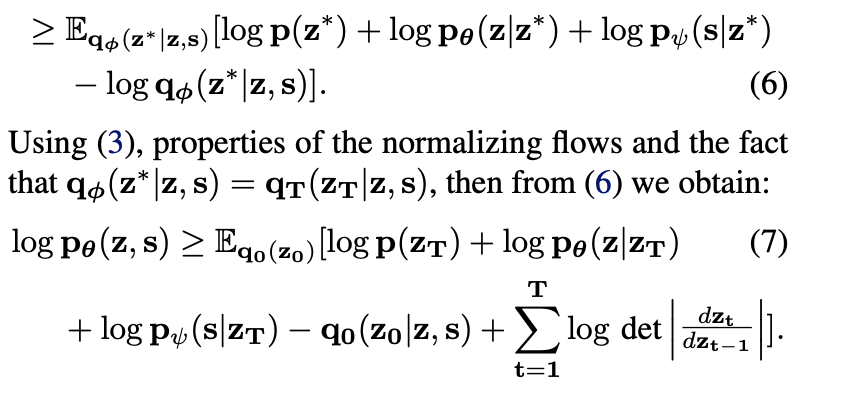

In [17]:
from tensorflow.keras.losses import MSE, categorical_crossentropy
def multinomial_loss_function(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t, beta=1.0, gamma=1.0): 
    """
    :param z_pred: shape: (batch_size, latent_dim), real valued, mean of p_theta(z|z*)
    :param z:       shape (batch_size, latent_dim), original z
    
    :param s_logit: shape: (batch_size, s_digit_dim + s_rot_dim), real valued logits, first 10 cols contain digit, rest are rot
    :param s:       shape: (batch_size, s_digit_dim + s_rot_dim), concated one-h encoding of digit and rot info
    
    :param z_0: first stochastic latent variable
    :param log_q_z0: log denisty of z_0
    
    :param z_t: last stochastic latent variable
    :param ldj: log det jacobian
    
    Note: elbo = log_p_zt + log_p_theta + log_p_psi - log_q_z0 + log_dets    [loss = -elbo]
    """
    
    
    log_p_zt = log_normal_pdf(z_t, mean=0.,  logvar=0.)
    
    log_p_theta = log_normal_pdf(z, mean=z_pred, logvar=0.) #log_normal_pdf(z, mean=z_pred, logvar=0.)
    
#
    # bad names, now s0, s1
    digit_p = -MSE(s[0], s_pred[0])
    thick_p = -MSE(s[1], s_pred[1])     
    
    log_p_psi = digit_p + thick_p 
     
    
    recons_loss = -(log_p_theta*gamma + log_p_psi)
    kl_loss = log_q_z0 - log_dets - log_p_zt


    loss = recons_loss + kl_loss*beta
    return tf.reduce_mean(loss)
  

  

def lf_reconstr_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t): 

    
    log_p_theta = log_normal_pdf(z, mean=z_pred, logvar=0.)
    
    #digit_p = -categorical_crossentropy(s[0], s_pred[0], from_logits=True)
    digit_p = log_normal_pdf(s[0], mean=s_pred[0], logvar=0.)
    rot_p = log_normal_pdf(s[1], mean=s_pred[1], logvar=0.)
    log_p_psi = tf.add(digit_p, rot_p)
    

    loss = -tf.reduce_mean(log_p_theta + log_p_psi)
    return loss


def lf_kl_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t): 
    log_p_zt = log_normal_pdf(z_t, mean=0.,  logvar=0.)
    loss = log_q_z0 - log_dets - log_p_zt
    return tf.reduce_mean(loss)


    

metrics = []
metrics.append(('reconstr_loss', lf_reconstr_loss))
metrics.append(('kl_loss', lf_kl_loss))

[('reconstr_loss',
  <function __main__.lf_reconstr_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t)>),
 ('kl_loss',
  <function __main__.lf_kl_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t)>)]

In [18]:


def build_filvm(latent_dim = 2, 
               flow_depth = 5, 
               inter_dims = [1024, 256, 16], 
               optimizer = tf.keras.optimizers.Adam(), 
               metrics = [], 
               loss_fn = None, 
               beta=1.0, 
               gamma=1.0, 
              ):

    input_z = Input(shape=(z_dim, ), batch_size=batch_size,name='z_in')
    input_s_d = Input(shape=(1, ), batch_size=batch_size,name='s_0')
    input_s_t = Input(shape=(1,), batch_size=batch_size,name='s_1')

    recnet1_in = [input_z, input_s_d, input_s_t]
    recnet1_in_cc = tf.keras.layers.concatenate(recnet1_in, axis=1)


    #############  Recnet 1 ##############
    x = Dense(inter_dims[0], activation='relu')(recnet1_in_cc)
    for dim in inter_dims[1:]:
        x = Dense(dim, activation='relu')(x)
    

    w = Dense(flow_dim * flow_depth, name='w')(x)
    u = Dense(flow_dim * flow_depth, name='u')(x)
    b = Dense(1 * flow_depth, name='b')(x)


    z0_mean = Dense(z_dim, name='z0_mean')(x)
    z0_log_var = Dense(z_dim, name='z0_log_var')(x)
    z0, log_q0 = Lambda(sampling2, output_shape=(z_dim,), name='z_0')([z0_mean, z0_log_var])

    recnet1 = Model(recnet1_in, [z0_mean, z0_log_var, z0, log_q0, w, u, b], name='recnet1')


    #############  Srn ##############
    x = Dense(inter_dims[0], activation='relu')(input_z)
    for dim in inter_dims[1:]:
        x = Dense(dim, activation='relu')(x)

    s_d_out = Dense(1, name='s_dig_out')(x)
    s_t_out = Dense(1, name='s_thc_out')(x)

    srn = Model(input_z, (s_d_out, s_t_out), name='srn')


    #####                      Flow             #####   
    pf_layers = [PlanarFlow() for _ in range(flow_depth)]

    

    #####                  Generative model             #####    
    gen_inputs1 = Input(shape=(z_dim,), batch_size=32, name='zt_full')
    gen_inputs2 = Input(shape=(z_dim,), batch_size=32, name='zt_0')
    gen_inputs3 = Input(shape=(z_dim,), batch_size=32, name='zt_1')


    # theta part
    x = Dense(inter_dims[-1], activation='relu', name="gm_theta_1")(gen_inputs1)
    for dim in reversed(inter_dims[:-1]):
        x = Dense(dim, activation='relu')(x)

    output_z = Dense(z_dim, name="gm_theta_4")(x)  

    # psi part
    output_s_d = Linear(input_dim=1, output_dim=1, name="s_0_pred")(tf.expand_dims(gen_inputs2[:,0],axis=1))
    output_s_t = Linear(input_dim=1, output_dim=1, name="s_0_pred")(tf.expand_dims(gen_inputs3[:,1],axis=1))



    # instantiate generative model
#     gm = Model(gen_inputs, output, name='generative_model')
    gm1 = Model(gen_inputs1, output_z, name='generative_model1')
    gm2 = Model(gen_inputs2, output_s_d, name='generative_model2')
    gm3 = Model(gen_inputs3, output_s_t, name='generative_model3')

    
    gm = (gm1, gm2, gm3)
    
    ## filvm ##
    filvm = FILVM(recnet1, srn, pf_layers, gm,  optimizer, beta=beta, gamma=gamma, )
    filvm.set_metrics(metrics)
    filvm.set_loss_fn(multinomial_loss_function)
    
    return filvm
    


In [19]:
filvm = build_filvm(loss_fn=multinomial_loss_function, metrics=metrics)
z_dim

4

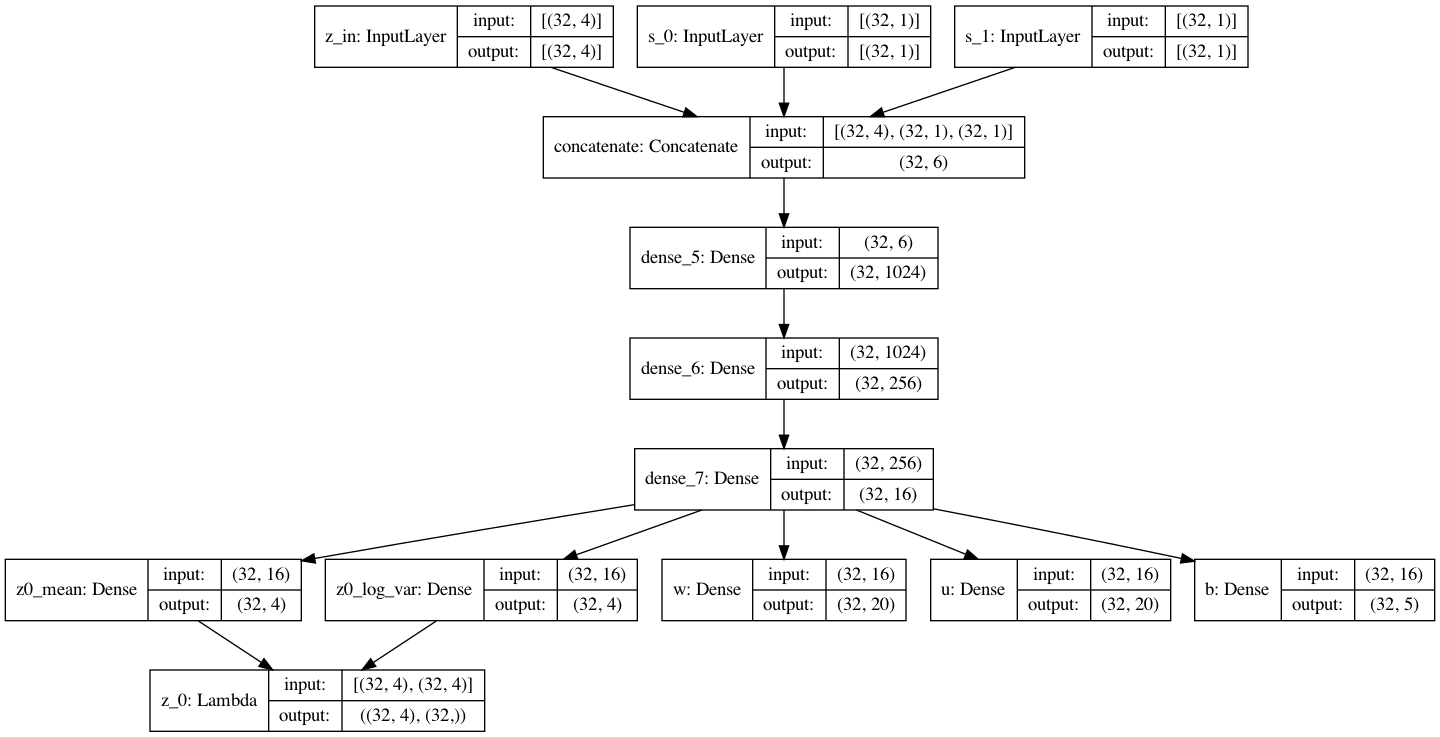

In [20]:
plot_model(filvm.recnet, show_shapes=True)

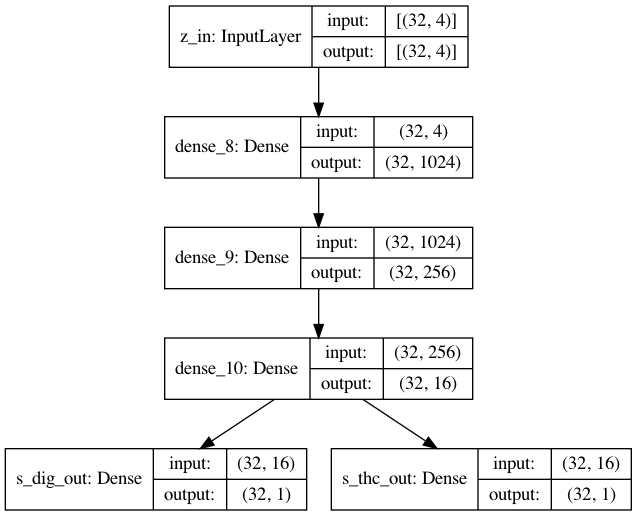

In [21]:
plot_model(filvm.srn, show_shapes=True)

In [22]:
# Planar flows

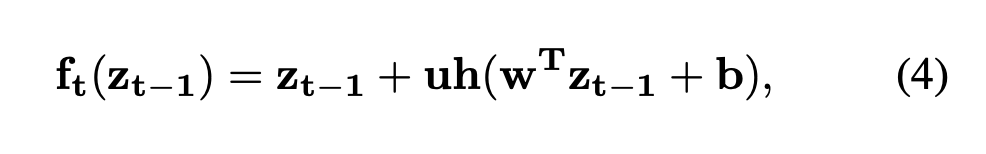 

h is tanh; w,u are vectors; b is scalar

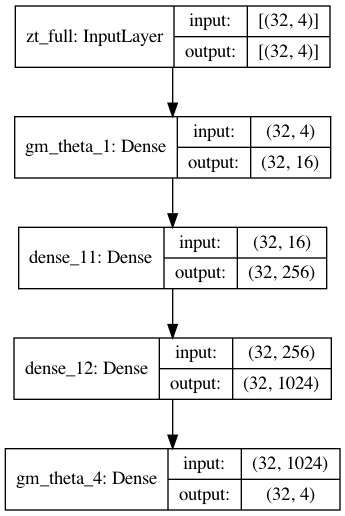

In [23]:
plot_model(filvm.gm1, show_shapes=True)

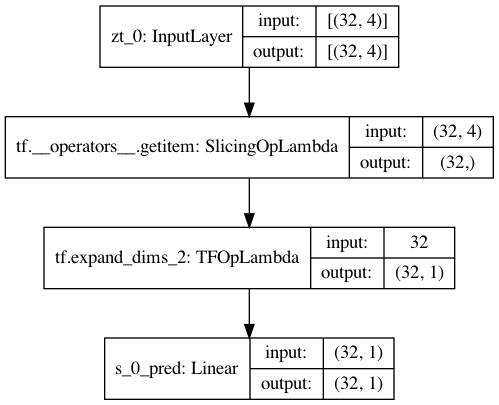

In [24]:
plot_model(filvm.gm2, show_shapes=True)

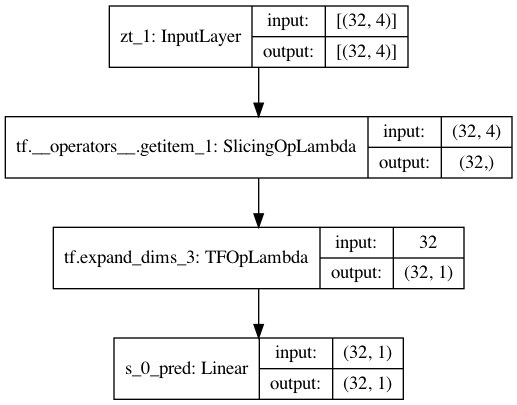

In [25]:
plot_model(filvm.gm3, show_shapes=True)

In [26]:
param_search = dict(flow_depth = flow_depth_options, 
                     inter_dims = inter_dims_options, 
                     optimizer = optimizer_options, 
                     beta= beta_options, 
                     gamma= gamma_options)




param_list = param_search_to_list(param_search)
len(param_list), param_list[0]

(1,
 {'gamma': 2.0,
  'beta': 0.5,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x10ddb3070>,
  'inter_dims': [1024, 128, 32],
  'flow_depth': 5})

In [27]:
trained = []

running: dep-5--inr-1024_128_32--opt-Adam--b-0_5--g-2_0--cv_full_loss--0
Epoch 1 Batch 0 Loss 1 24.8587
tr1_reconstr_loss 83.59139
tr1_kl_loss 0.20206705


Epoch 1 Batch 0 Loss 2 17.2396
tr2_reconstr_loss 78.77772
tr2_kl_loss 0.034126833
tr2_loss_srn_d 0.18630026
tr2_loss_srn_t 0.3683787
tr2_loss_srn 0.554679


Epoch 1 Loss 595.9698
********** CV **********
Epoch 1 Loss 352.9375
cv_reconstr_loss 65.59381
cv_kl_loss 1.6987488


Full Time taken for 1 epochs is 41.86591911315918 sec




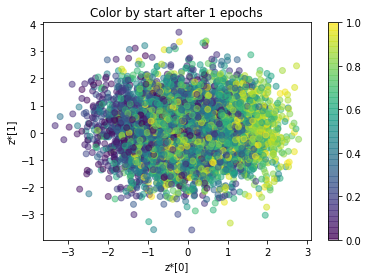

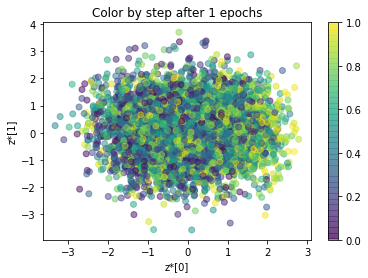

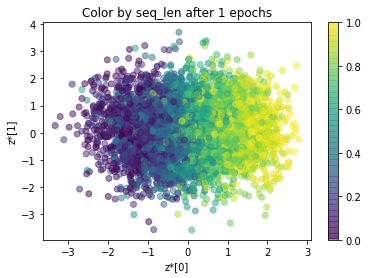

<Figure size 432x288 with 0 Axes>

In [28]:


watch =["cv_full_loss"]

for rep in range(reps):
    for params in param_list:
        for w in watch:

            id_str = make_id(params) + "--{}--{}".format(w, rep)
            print("running:", id_str)

            log_dir = "{}/{}".format(root_logdir, id_str)
            os.makedirs(log_dir, exist_ok=True)

            filvm = build_filvm(**params,loss_fn=multinomial_loss_function, metrics=metrics)

            trained.append((id_str, filvm))
            
            
            filvm.fit(epochs, log_dir, ds1=ds1, ds2=ds2, ds_test=ds_test, batch_size=BATCH_SIZE,
                      show=False, plot_freq=5, early_stop=EARLY_STOP, watch=w)
            

            n_ep = len(filvm.track[watch[0]])
        
        
            make_plots((z_cv, s0_cv, s1_cv), filvm, log_dir, n_ep,
               prefixs=["start", "step", "seq_len"], cs=[s0_cv, s1_cv, s_len_cv], save=False)
   

### View fit models

dep-5--inr-1024_128_32--opt-Adam--b-0_5--g-2_0--cv_full_loss--0


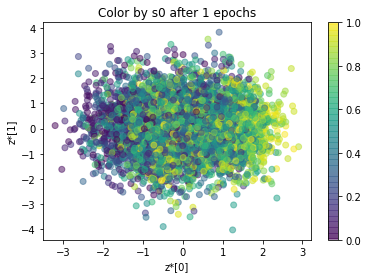

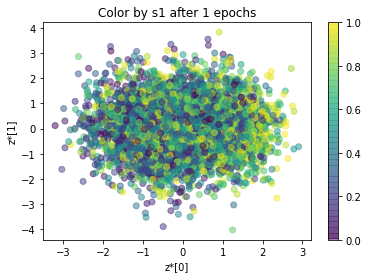

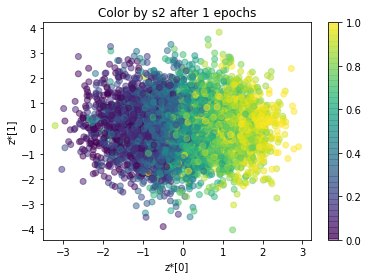

<Figure size 432x288 with 0 Axes>

In [29]:
max_show = 4
for i, (id_str, model) in enumerate(trained):
    print(id_str)
    
    n_ep = len(model.track[watch[0]])

    make_plots((z_cv, s0_cv, s1_cv), model, "", n_ep,
           prefixs=["s0", "s1", "s2"], cs=[s0_cv, s1_cv, s_len_cv], save=False)

    if i > max_show - 2:
        break

### Save trained filvm

In [30]:
find = "dep-10--inr-1024_128_32--opt-RMSprop--b-0_2--k-1_0--g-2_0--cv_full_loss--0"

for i, (id_str, filvm) in enumerate(trained):

    if id_str == find:
        print("found model, it is now filvm")
        break


In [31]:
save_ilvm(filvm, save_loc + "/lens_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: good_filvm/models/recnet1/assets
INFO:tensorflow:Assets written to: good_filvm/models/srn/assets
INFO:tensorflow:Assets written to: good_filvm/models/generative_model1/assets
INFO:tensorflow:Assets written to: good_filvm/models/generative_model2/assets
INFO:tensorflow:Assets written to: good_filvm/models/generative_model3/assets


## Make figures

Sequences generated by changing z*[0] from -3 to 3
__________________________________________________
151 160 175 194 213 233 254 275 296
159 169 185 203 223 244 265 287 309
187 200 218 238 260 282 305 328 351
245 268 289 312 336 360 385 410 435 460
339 379 405 430 455 481 507 534 560 586 612 638 664
454 517 547 571 594 618 643 667 692 717 742 766 790 814 838 861 884 907
557 645 682 708 731 754 776 799 822 844 867 889 912 934 956 977 998 1019 1040 1060 1080 1100 1120
674 791 837 867 891 914 937 960 983 1006 1028 1050 1071 1092 1112 1131 1150 1169 1188 1207 1225 1243 1261 1278 1296 1313
797 945 1001 1036 1062 1085 1108 1130 1153 1175 1198 1219 1241 1261 1281 1301 1319 1338 1355 1372 1389 1405 1421 1436 1451 1467 1482 1496 1511 1526
924 1104 1171 1211 1239 1263 1285 1307 1329 1351 1373 1394 1415 1435 1455 1474 1493 1510 1528 1545 1561 1576 1592 1606 1621 1635 1648 1661 1674 1686 1698 1710 1722 1733


Sequences generated by changing z*[1] from -3 to 3
_____________________________________

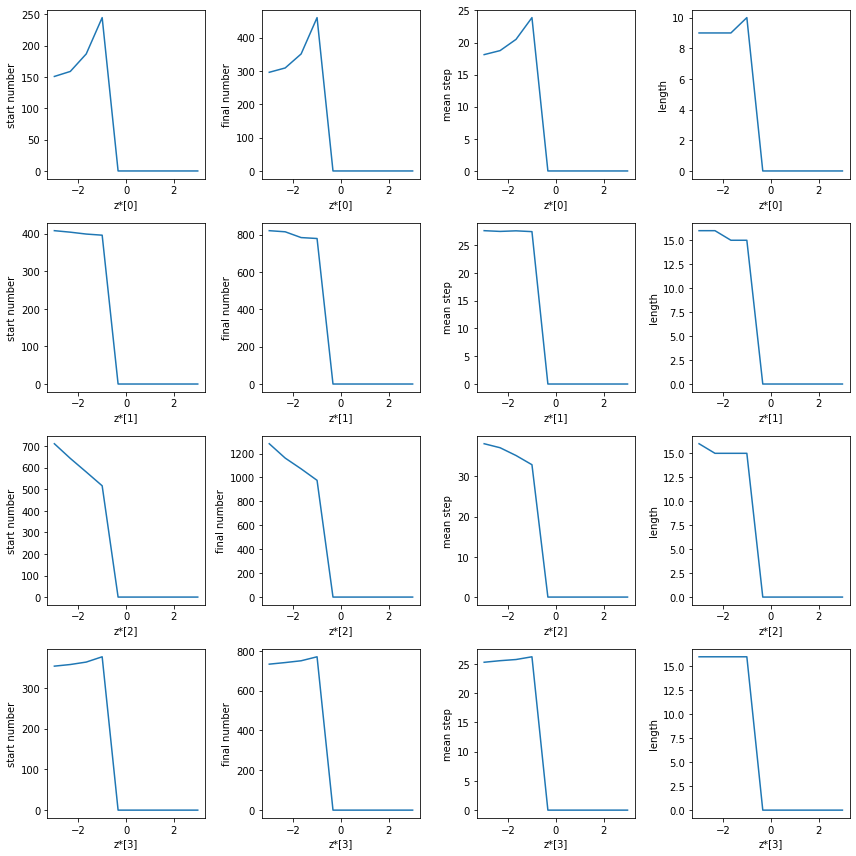

In [33]:
fig, axs = plt.subplots(z_dim, 4, figsize=(12,12))

for dim in range(z_dim):
    n = 10
    rng = (-3,3)
    # dim = 0

    z_star = np.zeros((n, z_dim))
    z_star[:,dim] = np.linspace(*rng, num=n)


    z_recons = filvm.gm1(z_star)
    context = z_recons

    dec_input = tf.expand_dims([START] * n, 1)
    dec_hidden = vae.initialize_hidden_state()[:n]

    pred_list = []
    pred_lens = tf.round(vae.len_decoder(context))

    max_len = int(max(pred_lens.numpy())[0])

    to_translate = np.zeros((n, max_len, 1)) #inp.shape


    for t in range(max_len):
        # passing enc_output to the decoder
        predictions, dec_hidden, = decoder((dec_input, context, dec_hidden))
        to_translate[:,t] = predictions
        dec_input = predictions

        
    print("Sequences generated by changing z*[{}] from {} to {}".format(dim, *rng))  
    print("_"*50)
    for i in range(n):

        pred = [x[0] for x in tf.round(to_translate[i]*SCALE).numpy()][:int(pred_lens[i])]
        pred_s = " ".join(map(str,map(int, pred)))
        print(pred_s)
    print("\n")
        

    to_plot = np.zeros((n, 4))
    for i in range(min(max_show, n)):

        pred = [x[0] for x in tf.round(to_translate[i]*SCALE).numpy()][:int(pred_lens[i])]

        pl = len(pred)
        start, end = pred[0], pred[-1]
        ms = np.mean(np.diff(pred))

        to_plot[i,0] = start
        to_plot[i,1] = end
        to_plot[i,2] = ms
        to_plot[i,3] = pl



    for i, lbl in enumerate(["start number", "final number",  "mean step", "length"]):
        axs[dim, i].plot(z_star[:,dim], to_plot[:,i])
        axs[dim, i].set_xlabel("z*[{}]".format(dim))
        axs[dim, i].set_ylabel(lbl)
    
fig.tight_layout()
plt.show()
